# Daytona SDK Examples

Load the Daytona SDK and create a sandbox

In [1]:
import base64
import io
import os
from pprint import pp

import matplotlib.pyplot as plt
from daytona_sdk import BarChart, CompositeChart, Daytona, LineChart, SessionExecuteRequest

daytona = Daytona()

In [2]:
sandbox = daytona.create()

print(sandbox.id)

1638856c-2230-431a-bc3c-c788294274a2


## Code and Command Execution

### Code Execution

In [3]:
response = sandbox.process.code_run('print("Hello World!")')
if response.exit_code != 0:
    print(f"Error: {response.exit_code} {response.result}")
else:
    print(response.result)

Hello World!



### Command Execution

In [4]:
response = sandbox.process.exec('echo "Hello World from exec!"', cwd="/home/daytona", timeout=10)
if response.exit_code != 0:
    print(f"Error: {response.exit_code} {response.result}")
else:
    print(response.result)

Hello World from exec!



### Exec Sessions

Sessions can be used to execute multiple commands in a single shell that preserves context between commands.

In [5]:
exec_session_id = "exec-session-1"
sandbox.process.create_session(exec_session_id)
session = sandbox.process.get_session(exec_session_id)
pp(session)
print()

# Execute the first command in the session
execCommand1 = sandbox.process.execute_session_command(exec_session_id, SessionExecuteRequest(command="export FOO=BAR"))
if execCommand1.exit_code != 0:
    print(f"Error: {execCommand1.exit_code} {execCommand1.output}")

# Get the command details
session_command = sandbox.process.get_session_command(exec_session_id, execCommand1.cmd_id)
pp(session_command)
print()

# Execute a second command in the session and see that the environment variable is set
execCommand2 = sandbox.process.execute_session_command(exec_session_id, SessionExecuteRequest(command="echo $FOO"))
if execCommand2.exit_code != 0:
    print(f"Error: {execCommand2.exit_code} {execCommand2.output}")
else:
    print(f"Output: {execCommand2.output}\n")

logs = sandbox.process.get_session_command_logs(exec_session_id, execCommand2.cmd_id)
print(f"Logs: {logs}")

Session(session_id='exec-session-1', commands=None, additional_properties={})

Command(id='140814c1-bb4f-4e7a-b66d-d698fd131aa2', command='export FOO=BAR', exit_code=0, additional_properties={})

Output: BAR


Logs: BAR



### Charts

Daytona automatically detects any plot creations while running remote code and saves them in `response.artifacts.charts`. This feature is available only for **Matplotlib** plots.

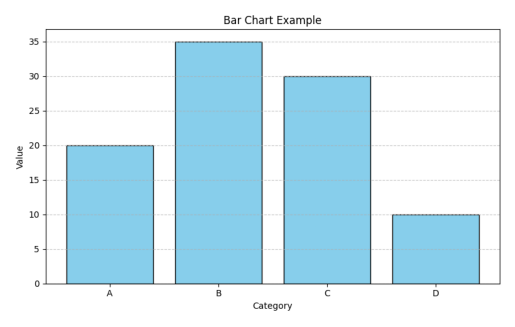

type: bar
title: Bar Chart Example
x_label: Category
y_label: Value
elements:

	label: A
	group: _container0
	value: 20

	label: B
	group: _container0
	value: 35

	label: C
	group: _container0
	value: 30

	label: D
	group: _container0
	value: 10


In [6]:
code = """
import matplotlib.pyplot as plt

# Data
categories = ['A', 'B', 'C', 'D']
values = [20, 35, 30, 10]

# Plot
plt.figure(figsize=(8, 5))
plt.bar(categories, values, color='skyblue', edgecolor='black')

# Labels and title
plt.xlabel('Category')
plt.ylabel('Value')
plt.title('Bar Chart Example')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
"""

response = sandbox.process.code_run(code)
chart = response.artifacts.charts[0]

img_data = base64.b64decode(chart.png)
img = plt.imread(io.BytesIO(img_data))
plt.imshow(img)
plt.axis("off")
plt.show()

print(f"type: {chart.type}")
print(f"title: {chart.title}")
if isinstance(chart, BarChart):
    print(f"x_label: {chart.x_label}")
    print(f"y_label: {chart.y_label}")
    print("elements:")
    for element in chart.elements:
        print(f"\n\tlabel: {element.label}")
        print(f"\tgroup: {element.group}")
        print(f"\tvalue: {element.value}")

#### Composite Charts
All subplots are included as individual `Chart` instances within the `elements` list of a parent `Chart` of type `CompositeChart`.

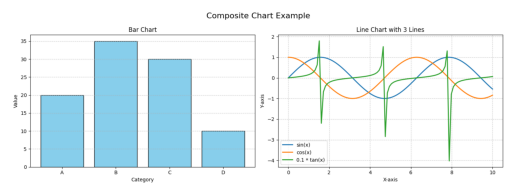

type: composite_chart
title: Composite Chart Example

	type: bar
	title: Bar Chart
	x_label: Category
	y_label: Value
	elements:

		label: A
		group: _container0
		value: 20

		label: B
		group: _container0
		value: 35

		label: C
		group: _container0
		value: 30

		label: D
		group: _container0
		value: 10

	type: line
	title: Line Chart with 3 Lines
	x_label: X-axis
	y_label: Y-axis
	x_ticks: [-2.0, 0.0, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0]
	x_tick_labels: ['−2', '0', '2', '4', '6', '8', '10', '12']
	x_scale: linear
	y_ticks: [-5.0, -4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0]
	y_tick_labels: ['−5', '−4', '−3', '−2', '−1', '0', '1', '2', '3']
	y_scale: linear
	elements:

		label: sin(x)
		points: [[0.0, 0.0], [0.10101010101010101, 0.1008384202581046], [0.20202020202020202, 0.2006488565226854], [0.30303030303030304, 0.2984138044476411], [0.40404040404040403, 0.3931366121483298], [0.5050505050505051, 0.48385164043793466], [0.6060606060606061, 0.5696341069089657], [0.7070707070707071, 0.64960

In [7]:
code = """
import matplotlib.pyplot as plt
import numpy as np

# Data for bar chart
categories = ['A', 'B', 'C', 'D']
bar_values = [20, 35, 30, 10]

# Data for line chart
x = np.linspace(0, 10, 100)
y1 = np.sin(x)
y2 = np.cos(x)
y3 = np.tan(x) * 0.1  # scaled to fit nicely

# Create a figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# --- Bar Chart (subplot 1) ---
ax1.bar(categories, bar_values, color='skyblue', edgecolor='black')
ax1.set_title('Bar Chart')
ax1.set_xlabel('Category')
ax1.set_ylabel('Value')
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# --- Line Chart with 3 lines (subplot 2) ---
ax2.plot(x, y1, label='sin(x)', linewidth=2)
ax2.plot(x, y2, label='cos(x)', linewidth=2)
ax2.plot(x, y3, label='0.1 * tan(x)', linewidth=2)
ax2.set_title('Line Chart with 3 Lines')
ax2.set_xlabel('X-axis')
ax2.set_ylabel('Y-axis')
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.legend()

# Add main title
fig.suptitle('Composite Chart Example', fontsize=16)

# Adjust layout and show
plt.tight_layout()
plt.show()
"""

response = sandbox.process.code_run(code)
chart = response.artifacts.charts[0]

img_data = base64.b64decode(chart.png)
img = plt.imread(io.BytesIO(img_data))
plt.imshow(img)
plt.axis("off")
plt.show()

print(f"type: {chart.type}")
print(f"title: {chart.title}")
if isinstance(chart, CompositeChart):
    for subplot in chart.elements:
        print(f"\n\ttype: {subplot.type}")
        print(f"\ttitle: {subplot.title}")
        if isinstance(subplot, BarChart):
            print(f"\tx_label: {subplot.x_label}")
            print(f"\ty_label: {subplot.y_label}")
            print("\telements:")
            for element in subplot.elements:
                print(f"\n\t\tlabel: {element.label}")
                print(f"\t\tgroup: {element.group}")
                print(f"\t\tvalue: {element.value}")
        elif isinstance(subplot, LineChart):
            print(f"\tx_label: {subplot.x_label}")
            print(f"\ty_label: {subplot.y_label}")
            print(f"\tx_ticks: {subplot.x_ticks}")
            print(f"\tx_tick_labels: {subplot.x_tick_labels}")
            print(f"\tx_scale: {subplot.x_scale}")
            print(f"\ty_ticks: {subplot.y_ticks}")
            print(f"\ty_tick_labels: {subplot.y_tick_labels}")
            print(f"\ty_scale: {subplot.y_scale}")
            print("\telements:")
            for element in subplot.elements:
                print(f"\n\t\tlabel: {element.label}")
                print(f"\t\tpoints: {element.points}")

## File System

- List Files
- Create Folder
- Upload File
- Download File
- Replace in Files
- Search Files
- Get File Info
- Move Files
- Delete File
- Set File Permissions

In [8]:
# List files in the sandbox
files = sandbox.fs.list_files("~")
pp(files)

# Create a new directory in the sandbox
new_dir = "new-dir"
sandbox.fs.create_folder(new_dir, "755")

file_path = os.path.join(new_dir, "data.txt")

# Add a new file to the sandbox
file_content = b"Hello, World!"
sandbox.fs.upload_file(file_path, file_content)

# Search for the file we just added
matches = sandbox.fs.find_files("~", "World!")
pp(matches)

# Replace the contents of the file
sandbox.fs.replace_in_files([file_path], "Hello, World!", "Goodbye, World!")

# Read the file
downloaded_file = sandbox.fs.download_file(file_path)
print("File content:", downloaded_file.decode("utf-8"))

# Change the file permissions
sandbox.fs.set_file_permissions(file_path, mode="777")

# Get file info
file_info = sandbox.fs.get_file_info(file_path)
pp(file_info)  # Should show the new permissions

# Move the file to the new location
new_file_path = "moved-data.txt"
sandbox.fs.move_files(file_path, new_file_path)

# Find the file in the new location
search_results = sandbox.fs.search_files("~", "moved-data.txt")
pp(search_results)

# Delete the file
sandbox.fs.delete_file(new_file_path)

[FileInfo(name='.bash_logout', is_dir=False, size=220, mod_time='2024-03-29 19:40:10 +0000 UTC', mode='-rw-r--r--', permissions='0644', owner='1001', group='1001', additional_properties={}),
 FileInfo(name='.bashrc', is_dir=False, size=3526, mod_time='2024-03-29 19:40:10 +0000 UTC', mode='-rw-r--r--', permissions='0644', owner='1001', group='1001', additional_properties={}),
 FileInfo(name='.cache', is_dir=True, size=4096, mod_time='2025-05-05 16:19:12.488119113 +0000 UTC', mode='drwxr-xr-x', permissions='0755', owner='1001', group='1001', additional_properties={}),
 FileInfo(name='.config', is_dir=True, size=4096, mod_time='2025-05-05 16:19:12.37911835 +0000 UTC', mode='drwxr-xr-x', permissions='0755', owner='1001', group='1001', additional_properties={}),
 FileInfo(name='.daytona', is_dir=True, size=4096, mod_time='2025-05-05 16:19:09.036094914 +0000 UTC', mode='drwxr-xr-x', permissions='0755', owner='1001', group='1001', additional_properties={}),
 FileInfo(name='.profile', is_dir=F

## Git

- Clone Repository
- Pull Repository
- List Branches
- Delete a Branch
- Create a Branch
- Checkout a Branch
- Git Log
- Git Status
- Git Add
- Git Commit

In [9]:
project_dir = "learn-typescript"

# Clone the repository
sandbox.git.clone("https://github.com/panaverse/learn-typescript", project_dir, "master")

sandbox.git.pull(project_dir)

branches = sandbox.git.branches(project_dir)
pp(branches)

ListBranchResponse(branches=['master'], additional_properties={})


## LSP

- Start Language Server
- Notify Language Server of Document Change
- Get Completions
- Document Symbols
- Workspace Symbols

In [10]:
project_dir = "learn-typescript"

# Search for the file we want to work on
matches = sandbox.fs.find_files(project_dir, "var obj1 = new Base();")
print("Matches:", matches)

# Start the language server
lsp = sandbox.create_lsp_server("typescript", project_dir)
lsp.start()

# Notify the language server of the document we want to work on
lsp.did_open(matches[0].file)

# Get symbols in the document
symbols = lsp.document_symbols(matches[0].file)
print("Symbols:", symbols)

# Fix the error in the document
sandbox.fs.replace_in_files([matches[0].file], "var obj1 = new Base();", "var obj1 = new E();")

# Notify the language server of the document change
lsp.did_close(matches[0].file)
lsp.did_open(matches[0].file)

# Get completions at a specific position
completions = lsp.completions(matches[0].file, {"line": 12, "character": 18})
print("Completions:", completions)

Matches: [Match(file='/home/daytona/learn-typescript/step13b_abstract_classes/app.ts', line=11, content='var obj1 = new Base();//Error, cannnot create a instance of a Abstract class', additional_properties={})]
Symbols: [LspSymbol(kind=5, location=LspLocation(range=Range(start=Position(line=1, character=0, additional_properties={}), end=Position(line=4, character=1, additional_properties={}), additional_properties={}), uri='file:///home/daytona/learn-typescript/step13b_abstract_classes/app.ts', additional_properties={}), name='Base', additional_properties={}), LspSymbol(kind=6, location=LspLocation(range=Range(start=Position(line=3, character=4, additional_properties={}), end=Position(line=3, character=28, additional_properties={}), additional_properties={}), uri='file:///home/daytona/learn-typescript/step13b_abstract_classes/app.ts', additional_properties={}), name='bar', additional_properties={}), LspSymbol(kind=6, location=LspLocation(range=Range(start=Position(line=2, character=4, 

## Sandbox Management

- List Sandboxes
- Stop Sandbox
- Start Sandbox
- Remove Sandbox

In [11]:
sandboxes = daytona.list()
print(f"Total sandboxes count: {len(sandboxes)}")

for s in sandboxes:
    print(s.id)
    pp(s.info())
    print()

Total sandboxes count: 3
1638856c-2230-431a-bc3c-c788294274a2
SandboxInfo(created='2025-05-05T16:19:07.586Z', name='', provider_metadata='{"state":"started","nodeDomain":"h1066.daytona.work","region":"us","class":"small","updatedAt":"2025-05-05T16:19:29.140Z","lastSnapshot":null,"cpu":2,"gpu":0,"memory":4,"disk":10,"autoStopInterval":15}', additional_properties={}, id='1638856c-2230-431a-bc3c-c788294274a2', image='daytonaio/ai-test:0.2.3', user='daytona', env={}, labels={}, public=False, target=<SandboxTargetRegion.US: 'us'>, resources=SandboxResources(cpu='2', memory='4Gi', disk='10Gi', gpu=None), state=<WorkspaceState.STARTED: 'started'>, error_reason=None, snapshot_state='None', snapshot_created_at=None, node_domain='h1066.daytona.work', region='us', class_name='small', updated_at='2025-05-05T16:19:29.140Z', last_snapshot=None, auto_stop_interval=15)

e6b9ce0e-c34c-4752-9176-d80a28ddd6f0
SandboxInfo(created='2025-05-05T16:15:21.475Z', name='', provider_metadata='{"state":"started","

In [12]:
daytona.stop(sandbox)

In [13]:
daytona.start(sandbox)

In [14]:
daytona.delete(sandbox)